## Import required libraries

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
%matplotlib inline
import warnings

In [2]:
# ignore unwanted warnings
warnings.filterwarnings('ignore')

## Data sources

### Load ticker data

In [3]:
def generate_ticker_returns(ticker):
    """Pulls financial data and computes yearly returns for a given ticker
    
    Args:
        ticker (str): the ticker symbol to download the financial data for
        
    Returns:
        dataframe: a pandas dataframe with yearly returns for the provided ticker
    """
    # download data sources from yfinance that covers the period for which we have ESG data
    df = yf.Ticker(ticker).history(start="2009-01-01", end="2023-01-01")
    # reset the index to access the Date column
    df.reset_index(inplace=True)
    # create a Year column from the Date column
    df['Year'] = df['Date'].dt.strftime('%Y')
    # convert the Year column to int64
    df['Year'] = df['Year'].astype('int')
    # keep only the Year and Close columns
    df = df[['Year','Close']]
    # pull the last occurance of each year to obtain a yearly breakdown of the prices
    df = df.groupby('Year').last()
    # compute the returns for the ticker
    df = df.pct_change()
    # clean up the initial NaN from the pct_change() call
    df.dropna(inplace=True)
    # rename the column header
    df.columns = ['Returns']
    
    # return the dataframe of yearly ticker returns
    return df

In [4]:
# generate ticker returns dataframes for target companies
tickers = ['AAPL', 'MSFT', 'CSCO', 'GOOG', 'INTC', 'NVDA', 'ORCL', 'TXN', '^GSPC']
tickers_dfs = list(map(generate_ticker_returns,tickers))

In [5]:
def create_alpha(ticker_df,market_df):
    """Nets out the corresponding market returns from those of the ticker
    
    Args:
        ticker_df (dataframe): dataframe of the ticker returns
        market_df (dataframe): dataframe of the sp500 returns
        
    Returns:
        dataframe: the ticker's returns dataframe with an added column for the alpha
    """
    # create the alpha column
    ticker_df['Alpha'] = ticker_df['Returns'] - market_df['Returns']
    
    # return the dataframe with the alpha column
    return ticker_df

In [6]:
# compute excess returns (returns above those of the S&P 500), also known as alpha, for each ticker dataframe
for ticker_df in tickers_dfs:
     ticker_df = create_alpha(ticker_df,tickers_dfs[-1])

# view a couple samples
display(tickers_dfs[0]) # apple_df
display(tickers_dfs[-1]) # sp500_df

,Returns,Alpha
Year,,
2010,0.530679,0.402852
2011,0.255580,0.255612
2012,0.325669,0.191612
2013,0.080695,-0.215318
2014,0.406226,0.292320
2015,-0.030137,-0.022871
2016,0.124805,0.029454
2017,0.484643,0.290444
2018,-0.053902,0.008471


,Returns,Alpha
Year,,
2010,0.127827,0.0
2011,-0.000032,0.0
2012,0.134057,0.0
2013,0.296012,0.0
2014,0.113906,0.0
2015,-0.007266,0.0
2016,0.095350,0.0
2017,0.194200,0.0
2018,-0.062373,0.0


### Load ESG scores

In [7]:
# load the ESG scores into a dataframe
ESG_data = Path("Sources/ESG Scores.csv")
ESG_df = pd.read_csv(ESG_data, index_col="Fiscal Year End Date",infer_datetime_format=True, parse_dates=True)
# view a sample
ESG_df.head()

,Organization ID,Fiscal Year,Special Value Flag,Feed Date,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,...,Asset4 Identifier,Organization ID.1,Refinitiv Business Classification Code,Primary Exchange,Status Flag (1 = Active),Organization Authority Identifier,Ticker,CUSIP,Sedol,ISIN
Fiscal Year End Date,,,,,,,,,,,,,,,,,,,,,
2010-12-25,18227,2010,500,9/25/2022,0.951624,0.515286,0.078947,0.953333,0.992754,0.833333,...,A4_00015,Intel Corporation,5710,NSM,1,4295906830,INTC,45814010,246324,US4581401001
2011-12-31,18227,2011,500,9/25/2022,0.905026,0.640013,0.375000,0.980263,0.979452,0.776923,...,A4_00015,Intel Corporation,5710,NSM,1,4295906830,INTC,45814010,246324,US4581401001
2012-12-29,18227,2012,500,9/25/2022,0.913084,0.913084,0.958333,0.981250,0.993333,0.778571,...,A4_00015,Intel Corporation,5710,NSM,1,4295906830,INTC,45814010,246324,US4581401001
2013-12-28,18227,2013,500,9/25/2022,0.856952,0.653476,0.450000,0.981250,0.993243,0.787671,...,A4_00015,Intel Corporation,5710,NSM,1,4295906830,INTC,45814010,246324,US4581401001
2014-12-27,18227,2014,500,9/25/2022,0.913875,0.648114,0.382353,0.981707,0.993421,0.783784,...,A4_00015,Intel Corporation,5710,NSM,1,4295906830,INTC,45814010,246324,US4581401001


In [8]:
# reset the index and only maintain relevant columns
ESG_df.reset_index(inplace=True)
ESG_df = ESG_df[['Fiscal Year','Ticker','ESG SCORE','ESG Combined Score','ESG Controversies Score','Resource Use Score','Emissions Score',
                 'Environmental Innovation Score','Workforce Score','Human Rights Score','Community Score','Product Responsibility Score','Management Score',
                 'Shareholders Score','CSR Strategy Score']]
# change the Fiscal Year column to Year
ESG_df.rename({'Fiscal Year':'Year'},axis=1,inplace=True)
# view a sample
ESG_df.head()

,Year,Ticker,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score
0,2010,INTC,0.951624,0.515286,0.078947,0.953333,0.992754,0.833333,0.994624,0.924242,0.972527,0.994048,0.980558,0.931705,0.974308
1,2011,INTC,0.905026,0.640013,0.375000,0.980263,0.979452,0.776923,0.972826,0.950000,0.959770,0.946429,0.825101,0.723286,0.976371
2,2012,INTC,0.913084,0.913084,0.958333,0.981250,0.993333,0.778571,0.983871,0.952830,0.927778,0.911765,0.909694,0.651531,0.969203
3,2013,INTC,0.856952,0.653476,0.450000,0.981250,0.993243,0.787671,0.983696,0.983607,0.927778,0.889535,0.554248,0.679120,0.970217
4,2014,INTC,0.913875,0.648114,0.382353,0.981707,0.993421,0.783784,0.973118,0.984615,0.907609,0.882022,0.921699,0.622825,0.968007


### Combine ticker returns and ESG data in the same dataframe

In [9]:
def combined_ticker_and_ESG_data(ticker_df,ticker):
    """Combines the ticker's returns and corresponding ESG data into a dataframe
    
    Args:
        ticker_df (dataframe): dataframe of the ticker returns
        ticker (str): the ticker symbol to pull ESG data for
        
    Returns:
        dataframe: the ticker's returns combined with its corresponding ESG data
    """
    # generate a dataframe for the ticker's ESG data
    ticker_esg_data_df = ESG_df.query('Ticker == @ticker')
    # turn the Year column to an index
    ticker_esg_data_df.set_index('Year',inplace=True) # this throws a 'SettingWithCopyWarning' warning that we purposely ignore
    # combine the two dataframes
    ticker_df = pd.concat([ticker_df,ticker_esg_data_df], axis="columns", join="inner")
    
    # return the dataframe with the combined returns and ESG data for the ticker
    return ticker_df

In [10]:
# combine ticker returns dataframes with their corresponding ESG data
combined_tickers_dfs = list(map(combined_ticker_and_ESG_data,tickers_dfs[:-1],tickers[:-1]))

# create an individual dataframe for each ticker
apple_df = combined_tickers_dfs[0]
msft_df = combined_tickers_dfs[1]
cisco_df = combined_tickers_dfs[2]
google_df = combined_tickers_dfs[3]
intel_df = combined_tickers_dfs[4]
nvidia_df = combined_tickers_dfs[5]
oracle_df = combined_tickers_dfs[6]
texinst_df = combined_tickers_dfs[7]
sp500_df = tickers_dfs[8]
# view a couple samples
display(apple_df)
display(nvidia_df)
display(sp500_df)

,Returns,Alpha,Ticker,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score
Year,,,,,,,,,,,,,,,,
2010,0.530679,0.402852,AAPL,0.598853,0.313315,0.027778,0.937500,0.587500,0.400000,0.467391,0.948276,0.744444,0.050000,0.572782,0.912762,0.595850
2011,0.255580,0.255612,AAPL,0.526378,0.277078,0.027778,0.937500,0.462500,0.432432,0.436170,0.954545,0.931818,0.048780,0.085181,0.858367,0.809074
2012,0.325669,0.191612,AAPL,0.565545,0.298397,0.031250,0.858974,0.448718,0.418919,0.366667,0.944444,0.837209,0.040541,0.399490,0.984184,0.772645
2013,0.080695,-0.215318,AAPL,0.602998,0.319356,0.035714,0.833333,0.423077,0.388889,0.388889,0.945946,0.642857,0.039474,0.728250,0.966735,0.765343
2014,0.406226,0.292320,AAPL,0.561743,0.297538,0.033333,0.807692,0.581081,0.385714,0.476744,0.585714,0.550000,0.041667,0.829580,0.923746,0.778793
2015,-0.030137,-0.022871,AAPL,0.542147,0.298851,0.055556,0.922222,0.621951,0.368421,0.578431,0.463415,0.549020,0.133333,0.719056,0.901042,0.769544
2016,0.124805,0.029454,AAPL,0.615581,0.375972,0.136364,0.904255,0.616279,0.392857,0.640351,0.455556,0.500000,0.555556,0.854309,0.884172,0.762481
2017,0.484643,0.290444,AAPL,0.683317,0.409840,0.136364,0.970000,0.670213,0.400000,0.867188,0.522222,0.671875,0.616667,0.866472,0.887041,0.762759
2018,-0.053902,0.008471,AAPL,0.718954,0.380310,0.041667,0.991525,0.728070,0.400000,0.750000,0.613208,0.878571,0.590909,0.940266,0.846423,0.755582


,Returns,Alpha,Ticker,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score
Year,,,,,,,,,,,,,,,,
2010,-0.175589,-0.303416,NVDA,0.606981,0.316649,0.026316,0.860000,0.659420,0.416667,0.876344,0.106061,0.884615,0.000000,0.931705,0.892822,0.683794
2011,-0.100000,-0.099968,NVDA,0.570155,0.570155,1.000000,0.717105,0.705479,0.392308,0.853261,0.100000,0.902299,0.000000,0.781754,0.990423,0.624764
2012,-0.109733,-0.243790,NVDA,0.634779,0.634779,1.000000,0.781250,0.793333,0.342857,0.865591,0.103774,0.905556,0.170588,0.970918,0.964796,0.851449
2013,0.335238,0.039225,NVDA,0.758774,0.758774,1.000000,0.856250,0.844595,0.349315,0.798913,0.795082,0.983333,0.168605,0.999488,0.940123,0.847473
2014,0.273958,0.160052,NVDA,0.782896,0.782896,1.000000,0.932927,0.875000,0.358108,0.876344,0.669231,0.777174,0.769663,0.996418,0.761003,0.859232
2015,0.671156,0.678422,NVDA,0.744623,0.744623,1.000000,0.970930,0.930380,0.347222,0.785000,0.371622,0.925000,0.781915,0.996630,0.685968,0.848534
2016,2.269603,2.174253,NVDA,0.733099,0.733099,1.000000,0.984694,0.929348,0.328947,0.856522,0.311828,0.917391,0.754545,0.992534,0.597056,0.849470
2017,0.819879,0.625679,NVDA,0.765966,0.765966,1.000000,0.940367,0.964646,0.350000,0.921642,0.459596,0.929104,0.776000,0.995029,0.568564,0.844828
2018,-0.308152,-0.245780,NVDA,0.757605,0.757605,0.857143,0.946281,0.978261,0.346154,0.954225,0.357759,0.926056,0.788321,0.997837,0.600166,0.843126


,Returns,Alpha
Year,,
2010,0.127827,0.0
2011,-0.000032,0.0
2012,0.134057,0.0
2013,0.296012,0.0
2014,0.113906,0.0
2015,-0.007266,0.0
2016,0.095350,0.0
2017,0.194200,0.0
2018,-0.062373,0.0


### Combine additional dataframes for analysis

In [11]:
# create a stock returns performance dataframe
stock_returns_performance_df = pd.concat([apple_df['Returns'],msft_df['Returns'],cisco_df['Returns'],google_df['Returns'],intel_df['Returns'],nvidia_df['Returns'],oracle_df['Returns'],texinst_df['Returns'],sp500_df['Returns']],axis=1,join='inner')
# set column names 
stock_returns_performance_df.columns = ['APPLE','MSFT','CISCO','GOOGLE','INTEL','NVIDIA','ORACLE','TEX INS','SP500']
# clean out any nulls and remove duplicates; which there shouldn't be any
stock_returns_performance_df = stock_returns_performance_df.dropna().drop_duplicates()
# view a sample
stock_returns_performance_df.head()

,APPLE,MSFT,CISCO,GOOGLE,INTEL,NVIDIA,ORACLE,TEX INS,SP500
Year,,,,,,,,,
2010,0.530679,-0.065246,-0.154971,-0.041953,0.062695,-0.175589,0.286125,0.270755,0.127827
2011,0.255580,-0.045157,-0.096172,0.087429,0.193964,-0.100000,-0.174621,-0.088760,-0.000032
2012,0.325669,0.057989,0.116055,0.095185,-0.120146,-0.109733,0.317170,0.087131,0.134057
2013,0.080695,0.442980,0.167266,0.584311,0.309200,0.335238,0.156823,0.462866,0.296012
2014,0.406226,0.275646,0.279758,-0.059656,0.442240,0.273958,0.189748,0.250924,0.113906


In [12]:
# create a stock alpha performance dataframe
stock_alpha_performance_df = pd.concat([apple_df['Alpha'],msft_df['Alpha'],cisco_df['Alpha'],google_df['Alpha'],intel_df['Alpha'],nvidia_df['Alpha'],oracle_df['Alpha'],texinst_df['Alpha']],axis=1,join='inner')
# set column names
stock_alpha_performance_df.columns = ['APPLE','MSFT','CISCO','GOOGLE','INTEL','NVIDIA','ORACLE','TEX INS']
# clean out any nulls and remove duplicates; which there shouldn't be any
stock_alpha_performance_df = stock_alpha_performance_df.dropna().drop_duplicates()
# view a sample
stock_alpha_performance_df.head()

,APPLE,MSFT,CISCO,GOOGLE,INTEL,NVIDIA,ORACLE,TEX INS
Year,,,,,,,,
2010,0.402852,-0.193073,-0.282798,-0.169780,-0.065132,-0.303416,0.158298,0.142928
2011,0.255612,-0.045125,-0.096140,0.087460,0.193996,-0.099968,-0.174589,-0.088729
2012,0.191612,-0.076068,-0.018002,-0.038872,-0.254203,-0.243790,0.183113,-0.046926
2013,-0.215318,0.146968,-0.128747,0.288299,0.013188,0.039225,-0.139189,0.166853
2014,0.292320,0.161739,0.165852,-0.173562,0.328333,0.160052,0.075842,0.137017


### Clean all data before conducting the analyses

In [13]:
# view NAs and clean the combined ticker returns and ESG data
print('Apple NAs status:')
display(apple_df.isna().sum())
apple_df = apple_df.dropna().drop_duplicates()
print('\nMSFT NAs status:')
display(msft_df.isna().sum())
msft_df = msft_df.dropna().drop_duplicates()
print('\nCisco NAs status:')
display(cisco_df.isna().sum())
cisco_df = cisco_df.dropna().drop_duplicates()
print('\nGoogle NAs status:')
display(google_df.isna().sum())
google_df = google_df.dropna().drop_duplicates()
print('\nIntel NAs status:')
display(intel_df.isna().sum())
intel_df = intel_df.dropna().drop_duplicates()
print('\nNvidia NAs status:')
display(nvidia_df.isna().sum())
nvidia_df = nvidia_df.dropna().drop_duplicates()
print('\nOracle NAs status:')
display(oracle_df.isna().sum())
oracle_df = oracle_df.dropna().drop_duplicates()
print('\nTex Inst. NAs status:')
display(texinst_df.isna().sum())
texinst_df = texinst_df.dropna().drop_duplicates()

# view NAs and clean the ESG scores dataframe, there are empties but there shouldn't be any duplicates
print('\nESG data NAs status:')
display(ESG_df.isna().sum())
ESG_df = ESG_df.dropna().drop_duplicates()

Apple NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


MSFT NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


Cisco NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


Google NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


Intel NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


Nvidia NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         0
ESG Combined Score                0
ESG Controversies Score           0
Resource Use Score                0
Emissions Score                   0
Environmental Innovation Score    0
Workforce Score                   0
Human Rights Score                0
Community Score                   0
Product Responsibility Score      0
Management Score                  0
Shareholders Score                0
CSR Strategy Score                0
dtype: int64


Oracle NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


Tex Inst. NAs status:


Returns                           0
Alpha                             0
Ticker                            0
ESG SCORE                         1
ESG Combined Score                1
ESG Controversies Score           1
Resource Use Score                1
Emissions Score                   1
Environmental Innovation Score    1
Workforce Score                   1
Human Rights Score                1
Community Score                   1
Product Responsibility Score      1
Management Score                  1
Shareholders Score                1
CSR Strategy Score                1
dtype: int64


ESG data NAs status:


Year                              0
Ticker                            0
ESG SCORE                         7
ESG Combined Score                7
ESG Controversies Score           7
Resource Use Score                7
Emissions Score                   7
Environmental Innovation Score    7
Workforce Score                   7
Human Rights Score                7
Community Score                   7
Product Responsibility Score      7
Management Score                  7
Shareholders Score                7
CSR Strategy Score                7
dtype: int64

## Analysis

### Data description and distribution - ticker returns

In [14]:
# observe the description of stock returns
stock_returns_performance_df.describe()

,APPLE,MSFT,CISCO,GOOGLE,INTEL,NVIDIA,ORACLE,TEX INS,SP500
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.301488,0.223432,0.098778,0.179980,0.081437,0.493917,0.126604,0.198994,0.109042
std,0.336121,0.255341,0.194608,0.291992,0.242093,0.782756,0.182242,0.206112,0.144637
min,-0.264042,-0.280248,-0.224628,-0.386713,-0.466427,-0.502646,-0.176311,-0.098574,-0.194428
25%,0.080695,0.057989,-0.034865,-0.010312,-0.022140,-0.109733,-0.029696,0.051743,-0.000032
50%,0.325669,0.226919,0.138126,0.095185,0.062695,0.335238,0.189748,0.250924,0.127827
75%,0.484643,0.425341,0.167266,0.355757,0.307120,0.819879,0.249368,0.367113,0.194200
max,0.889578,0.575580,0.457614,0.651706,0.442240,2.269603,0.368894,0.467459,0.296012


In [15]:
# plot a bar chart of the stock returns


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [16]:
# observe the description of stock alphas
stock_alpha_performance_df.describe()

,APPLE,MSFT,CISCO,GOOGLE,INTEL,NVIDIA,ORACLE,TEX INS
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.192445,0.114389,-0.010264,0.070937,-0.027606,0.384875,0.017561,0.089951
std,0.259578,0.164132,0.158070,0.210386,0.192014,0.725998,0.126142,0.121533
min,-0.215318,-0.193073,-0.282798,-0.192285,-0.309477,-0.308218,-0.174589,-0.093618
25%,0.008471,-0.045125,-0.128747,-0.078299,-0.208402,-0.243790,-0.095348,-0.009322
50%,0.191612,0.161739,-0.018002,0.052061,-0.007786,0.160052,0.055169,0.106854
75%,0.292320,0.255842,0.118484,0.161557,0.104637,0.678422,0.099967,0.154424
max,0.660478,0.286800,0.228088,0.452865,0.328333,2.174253,0.183113,0.273260


In [17]:
# plot a bar chart of the stock alphas


Observations:
<ol>1. </ol>
<ol>2. </ol>

### Data description and distribution - ESG data

In [18]:
# observed the description of ESG data
ESG_df.describe()

,Year,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,2015.567010,0.755714,0.558715,0.402963,0.931577,0.892858,0.586839,0.882461,0.686444,0.894162,0.636796,0.781256,0.606406,0.744611
std,3.514574,0.152577,0.201458,0.383672,0.104438,0.131547,0.206265,0.133715,0.325744,0.119383,0.326234,0.250125,0.271437,0.244802
min,2010.000000,0.435804,0.225454,0.005000,0.408046,0.423077,0.323529,0.366667,0.000000,0.453333,0.000000,0.085181,0.007677,0.075643
25%,2013.000000,0.606981,0.395241,0.055556,0.911765,0.855191,0.400000,0.846535,0.583969,0.880208,0.347985,0.623414,0.435910,0.599912
50%,2016.000000,0.806383,0.526480,0.258065,0.974820,0.952055,0.542553,0.926710,0.834821,0.943478,0.776000,0.891698,0.645424,0.843126
75%,2019.000000,0.882782,0.751087,0.812500,0.991279,0.973404,0.718750,0.972826,0.933962,0.964286,0.932306,0.982088,0.824533,0.923218
max,2022.000000,0.951624,0.925424,1.000000,0.998927,0.996528,0.993750,0.997642,0.989899,0.997951,0.994048,0.999488,0.990423,0.976371


In [19]:
# plot charts to display relationships in the ESG data


Observations:
<ol>1. </ol>
<ol>2. </ol>

### Ticker returns and ESG data visualizations

In [20]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Apple


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [21]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - MSFT


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [22]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Cisco


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [23]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Google


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [24]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Intel


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [25]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Nvidia


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [26]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Oracle


Observations:
<ol>1. </ol>
<ol>2. </ol>

In [27]:
# plot charts that combine ticker returns and ESG data views (bar and line graphs) - Tex Inst.


Observations:
<ol>1. </ol>
<ol>2. </ol>

### Ticker to ESG data correlation

In [28]:
def correlate_data(ticker_df):
    """Computes the correlation coefficients between the ticker's returns and their corresponding ESG data
    
    Args:
        ticker_df (dataframe): dataframe of the combined ticker and ESG data to correlate
        
    Returns:
        dataframe: the correlation table of the ticker's returns and their corresponding ESG data
    """
    # compute the correlation
    ticker_df = ticker_df[['Alpha','ESG SCORE','ESG Combined Score','ESG Controversies Score','Resource Use Score','Emissions Score','Environmental Innovation Score',
                     'Workforce Score','Human Rights Score','Community Score','Product Responsibility Score','Management Score','Shareholders Score',
                     'CSR Strategy Score']].corr()
    
    # return the correlated dataframe
    return ticker_df

,Alpha,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score
Alpha,1.000000,0.288468,0.202932,-0.146804,0.397987,0.471970,0.004762,0.266352,0.076574,0.403160,0.249784,0.006141,-0.503468,-0.009351
ESG SCORE,0.288468,1.000000,0.915572,0.018387,0.693878,0.885219,0.174808,0.871592,-0.101856,0.464654,0.824194,0.719675,-0.643077,0.400607
ESG Combined Score,0.202932,0.915572,1.000000,0.418920,0.667833,0.792527,0.063324,0.924979,-0.360700,0.203364,0.942676,0.769150,-0.596656,0.332829
ESG Controversies Score,-0.146804,0.018387,0.418920,1.000000,0.093654,-0.028363,-0.237262,0.331705,-0.666789,-0.543539,0.482725,0.287299,-0.031399,-0.077054
Resource Use Score,0.397987,0.693878,0.667833,0.093654,1.000000,0.738090,0.160354,0.771175,-0.157964,0.587316,0.742758,0.287955,-0.840423,0.142931
Emissions Score,0.471970,0.885219,0.792527,-0.028363,0.738090,1.000000,-0.000286,0.878603,-0.293737,0.378590,0.779290,0.695235,-0.805052,0.416493
Environmental Innovation Score,0.004762,0.174808,0.063324,-0.237262,0.160354,-0.000286,1.000000,0.072622,0.605307,0.609337,-0.037958,-0.407695,-0.019821,0.338996
Workforce Score,0.266352,0.871592,0.924979,0.331705,0.771175,0.878603,0.072622,1.000000,-0.453007,0.243142,0.907490,0.715148,-0.734572,0.431730
Human Rights Score,0.076574,-0.101856,-0.360700,-0.666789,-0.157964,-0.293737,0.605307,-0.453007,1.000000,0.555041,-0.518717,-0.587731,0.302073,-0.076517
Community Score,0.403160,0.464654,0.203364,-0.543539,0.587316,0.378590,0.609337,0.243142,0.555041,1.000000,0.211580,-0.217111,-0.468239,0.287691


Text(0.5, 1.0, 'Correlation of excess returns to ESG scores - 2010 to 2022: Apple')

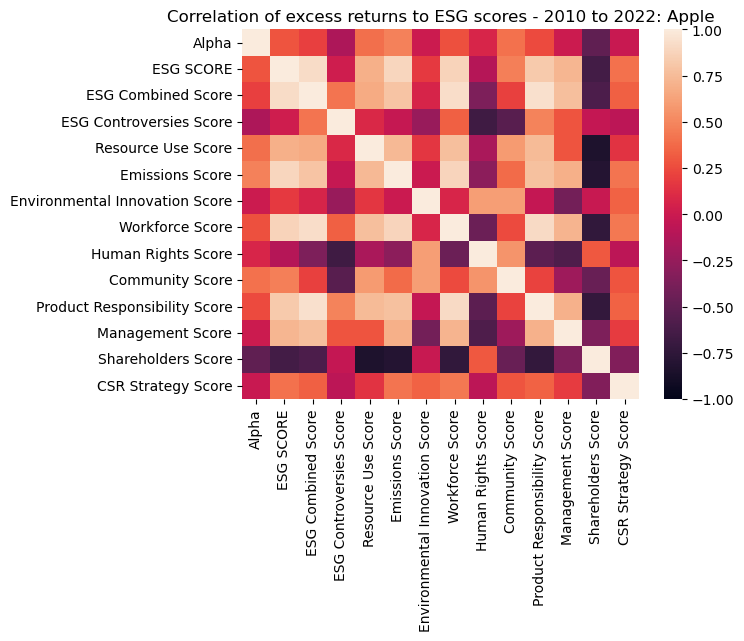

In [29]:
### Ticker to ESG data correlation - Apple ###

# compute the correlation of ticker alpha and its related ESG data; only include relevant columns
returns_ESG_corr = correlate_data(apple_df)
# display the correlation table
display(returns_ESG_corr)
# display a heatmap of correlation dataframe
sns.heatmap(returns_ESG_corr,vmin=-1,vmax=1)
plt.title('Correlation of excess returns to ESG scores - 2010 to 2022: Apple')

Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

,Alpha,ESG SCORE,ESG Combined Score,ESG Controversies Score,Resource Use Score,Emissions Score,Environmental Innovation Score,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score
Alpha,1.000000,0.456474,0.314125,0.239632,0.690451,-0.338848,-0.914544,0.890434,0.130880,0.068381,0.586637,0.523761,-0.832336,0.447708
ESG SCORE,0.456474,1.000000,0.203787,0.030444,-0.153951,-0.154836,-0.290393,0.192648,0.273541,0.387236,0.423008,0.818938,-0.367794,-0.092977
ESG Combined Score,0.314125,0.203787,1.000000,0.984765,0.050038,0.338760,-0.117510,0.013891,0.065731,0.464565,0.041579,0.070845,-0.178668,-0.375606
ESG Controversies Score,0.239632,0.030444,0.984765,1.000000,0.078431,0.373362,-0.068395,-0.020035,0.018524,0.405523,-0.032683,-0.073126,-0.117087,-0.366965
Resource Use Score,0.690451,-0.153951,0.050038,0.078431,1.000000,-0.320171,-0.810186,0.823423,0.239837,-0.114184,0.508819,-0.087797,-0.705686,0.664904
Emissions Score,-0.338848,-0.154836,0.338760,0.373362,-0.320171,1.000000,0.224039,-0.338667,0.149601,0.142901,0.079383,-0.315612,0.104377,-0.430015
Environmental Innovation Score,-0.914544,-0.290393,-0.117510,-0.068395,-0.810186,0.224039,1.000000,-0.953551,-0.164501,0.165499,-0.780076,-0.422175,0.917640,-0.484454
Workforce Score,0.890434,0.192648,0.013891,-0.020035,0.823423,-0.338667,-0.953551,1.000000,0.094675,-0.210478,0.618763,0.349641,-0.805405,0.605326
Human Rights Score,0.130880,0.273541,0.065731,0.018524,0.239837,0.149601,-0.164501,0.094675,1.000000,0.624254,0.390505,-0.212387,-0.312908,0.110302
Community Score,0.068381,0.387236,0.464565,0.405523,-0.114184,0.142901,0.165499,-0.210478,0.624254,1.000000,-0.180652,-0.159826,0.095055,-0.097806


Text(0.5, 1.0, 'Correlation of excess returns to ESG scores - 2010 to 2022: MSFT')

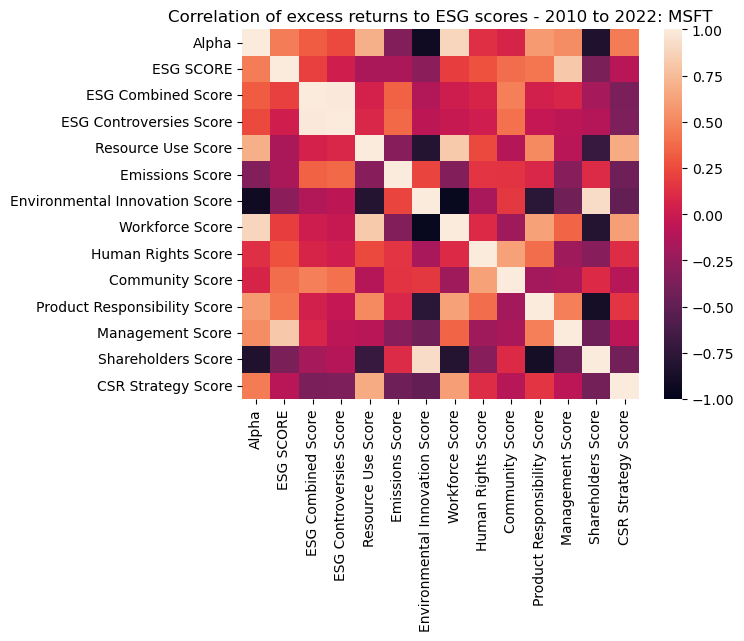

In [30]:
### Ticker to ESG data correlation - MSFT ###

# compute the correlation of ticker alpha and its related ESG data; only include relevant columns
returns_ESG_corr = correlate_data(msft_df)
# display the correlation table
display(returns_ESG_corr)
# display a heatmap of correlation dataframe
sns.heatmap(returns_ESG_corr,vmin=-1,vmax=1)
plt.title('Correlation of excess returns to ESG scores - 2010 to 2022: MSFT')

Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

In [31]:
### Ticker to ESG data correlation - Cisco ###



Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

In [32]:
### Ticker to ESG data correlation - Google ###



Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

In [33]:
### Ticker to ESG data correlation - Intel ###



Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

In [34]:
### Ticker to ESG data correlation - Nvidia ###



Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

In [35]:
### Ticker to ESG data correlation - Oracle ###



Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>

In [36]:
### Ticker to ESG data correlation - Tex Inst. ###



Observations:
<ol>1. </ol>
<ol>2. </ol>
<ol>3. </ol>